# Audio Classification: Speaker & Language

This notebook does the following:
1. Use a single **metadata CSV** to label both **speaker** and **language**.
2. Extract **MFCC features** from each audio file.
3. Perform **binary classification** separately for:
   - **Speaker** (Jeevan vs. Not_Jeevan)
   - **Language** (English vs. Not_English)
4. Use **k-Fold Cross-Validation** to evaluate performance (accuracy, precision, recall, F1) and generate confusion matrices.

In [2]:
#Importing ALl libraries
import os
import pandas as pd
import librosa
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Data Collection
__ Add Text Here

* Youtube
* Google Photos
* Facebook and Messenger
* Recorded to balance Data

# Data Pre Processing
__ Add text here

And code if needed. Or link to Github
* Used yt_dlp to download just the audio from youtube videos (These videos contain just my speech). No copyright infriengement intended. The channel used is in the codecell.
* Used __ to convert all video into audio
* Used librosa, ffemg to trim audio data into equal slices of 7 seconds (source for why that's suitable), removed silence, and added empty voice when a segment would be less than 7 seconds.

## What needs to be done:
These factors might result in some inaccuracy.
* The audio is recorded from a phone, often with a lot of wind or people in the background. So, there's some noise that needs to be cleaned.
* Some data is labeled as one class but has data from both classes. 
    * In conversations when both people are speaking in one segment, I classified it based on whoever is speaking for a longer time duration. 
    * People who speak Nepali also sprinkle English words in between, again I used the majority time rule to label data.

# Data Labeling
The most challenging part after fining the data was labeling.

__ Add more__

# Data Analysis

## Initial Distribution: 
Total Files: 561

Counts by Speaker:
  speaker_label  count
0        Jeevan    418
1    Not_Jeevan    143

Counts by Language:
  language_label  count
0    Not_English    350
1        English    211
Add image of initial distribution here and then show the new one.

Total Files: 823

Counts by Speaker:
  speaker_label  count
0        Jeevan    418
1    Not_Jeevan    405

Counts by Language:
  language_label  count
0    Not_English    434
1        English    389


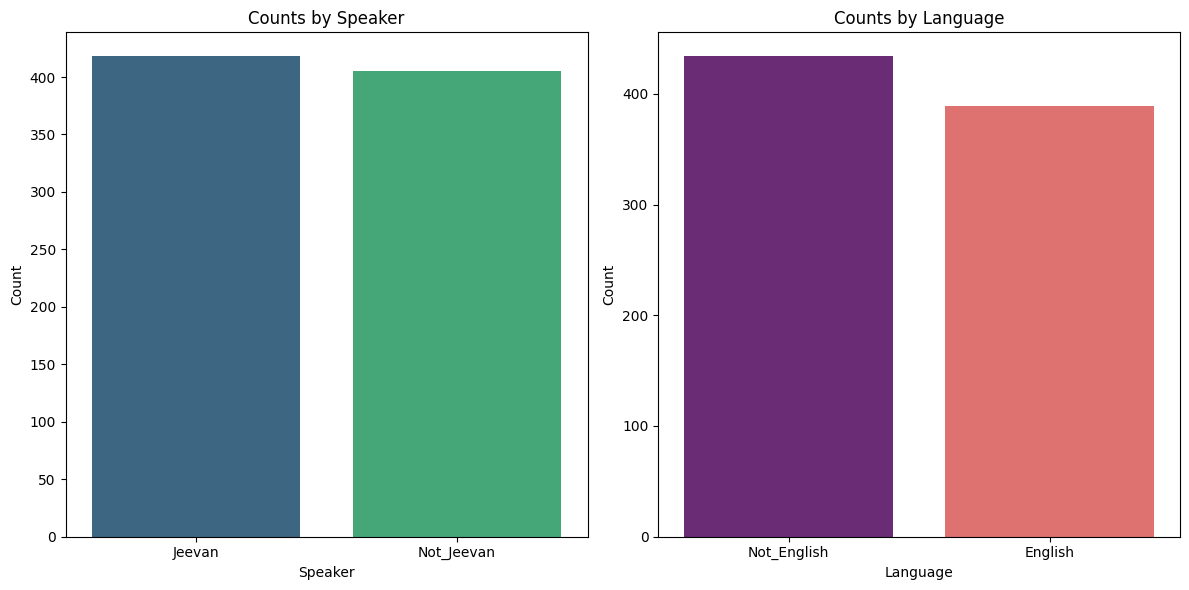

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress FutureWarnings from seaborn (or other libraries)
warnings.filterwarnings("ignore", category=FutureWarning)

# Load the CSV file, which already has a header row
df = pd.read_csv('data/metadata.csv') 

# Total data statistics
total_files = len(df)
print("Total Files:", total_files)

# Statistics by speaker
speaker_counts = df['speaker_label'].value_counts().reset_index()
speaker_counts.columns = ['speaker_label', 'count']
print("\nCounts by Speaker:")
print(speaker_counts)

# Statistics by language
language_counts = df['language_label'].value_counts().reset_index()
language_counts.columns = ['language_label', 'count']
print("\nCounts by Language:")
print(language_counts)

# Visualization: Bar plots for speaker and language counts
plt.figure(figsize=(12, 6))

# Bar plot for speaker counts
plt.subplot(1, 2, 1)
sns.barplot(data=speaker_counts, x='speaker_label', y='count', palette="viridis")
plt.title("Counts by Speaker")
plt.xlabel("Speaker")
plt.ylabel("Count")

# Bar plot for language counts
plt.subplot(1, 2, 2)
sns.barplot(data=language_counts, x='language_label', y='count', palette="magma")
plt.title("Counts by Language")
plt.xlabel("Language")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


In [11]:

def extract_features(file_path, sr=16000, n_mfcc=13):
    """
    Loads the audio file, extracts MFCC features, and returns the averaged MFCCs.
    """
    y, sr = librosa.load(file_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)
    return mfcc_mean

def build_dataset(metadata_csv, audio_dir):
    """
    Reads metadata from a CSV that has at least 3 columns:
        - filename
        - speaker_label (e.g., "Jeevan" or "Not_Jeevan")
        - language_label (e.g., "English" or "Not_English")
    """
    df = pd.read_csv(metadata_csv)
    X, y_speaker, y_language = [], [], []
    for _, row in df.iterrows():
        file_path = os.path.join(audio_dir, row['filename'])
        X.append(extract_features(file_path))
        y_speaker.append(1 if row['speaker_label'].lower() == 'jeevan' else 0)
        y_language.append(1 if row['language_label'].lower() == 'english' else 0)
    return np.array(X), np.array(y_speaker), np.array(y_language)

def evaluate_classifier(X, y, n_splits=5):
    """
    Performs k-Fold cross-validation, returns classification metrics and a confusion matrix.
    """
    clf = SVC(kernel='linear', probability=True, random_state=42)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    y_pred = cross_val_predict(clf, X, y, cv=skf)
    return classification_report(y, y_pred, target_names=["Class 0", "Class 1"]), confusion_matrix(y, y_pred)

In [13]:
# Paths to metadata CSV and audio files folder
metadata_csv_path = "data/metadata.csv"
audio_directory = "data/audio_data"

# Build dataset
X, y_speaker, y_language = build_dataset(metadata_csv_path, audio_directory)

# Models Used Use K-fold cross validation

In [14]:
# Speaker Classification
speaker_report, speaker_cm = evaluate_classifier(X, y_speaker, n_splits=5)
print("=== Speaker Classification (Jeevan vs. Not_Jeevan) ===")
print("Classification Report:\n", speaker_report)
print("Confusion Matrix:\n", speaker_cm)


=== Speaker Classification (Jeevan vs. Not_Jeevan) ===
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.86      0.86      0.86       405
     Class 1       0.86      0.86      0.86       418

    accuracy                           0.86       823
   macro avg       0.86      0.86      0.86       823
weighted avg       0.86      0.86      0.86       823

Confusion Matrix:
 [[347  58]
 [ 58 360]]


In [15]:
# Language Classification
language_report, language_cm = evaluate_classifier(X, y_language, n_splits=5)
print("\n=== Language Classification (English vs. Not_English) ===")
print("Classification Report:\n", language_report)
print("Confusion Matrix:\n", language_cm)



=== Language Classification (English vs. Not_English) ===
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.92      0.87      0.89       434
     Class 1       0.86      0.91      0.89       389

    accuracy                           0.89       823
   macro avg       0.89      0.89      0.89       823
weighted avg       0.89      0.89      0.89       823

Confusion Matrix:
 [[378  56]
 [ 34 355]]


# Comparison of All models